In [1]:
# --- INLINE SETUP (run if starting fresh) ---
import os, subprocess, sys

# Config
REPO_URL       = "https://github.com/ClaudiaCPach/CNNs-distracted-driving"
REPO_DIRNAME   = "CNNs-distracted-driving"
BRANCH         = "main"
PROJECT_ROOT   = f"/content/{REPO_DIRNAME}"
DRIVE_PATH     = "/content/drive/MyDrive/TFM"
DRIVE_DATA_ROOT = f"{DRIVE_PATH}/data"
FAST_DATA      = "/content/data"
DATASET_ROOT   = DRIVE_DATA_ROOT
OUT_ROOT       = f"{DRIVE_PATH}/outputs"
CKPT_ROOT      = f"{DRIVE_PATH}/checkpoints"

# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Clone/update repo
def sh(cmd):
    print(f"$ {cmd}")
    rc = subprocess.call(cmd, shell=True, executable="/bin/bash")
    if rc != 0:
        raise RuntimeError(f"Command failed: {cmd}")

if os.path.isdir(PROJECT_ROOT):
    sh(f"cd {PROJECT_ROOT} && git pull --rebase origin {BRANCH}")
else:
    sh(f"git clone --branch {BRANCH} {REPO_URL} {PROJECT_ROOT}")

# Install
sh(f"pip install -q -e {PROJECT_ROOT}")

# Set env vars
os.environ["DRIVE_PATH"] = DRIVE_PATH
os.environ["DATASET_ROOT"] = DATASET_ROOT
os.environ["OUT_ROOT"] = OUT_ROOT
os.environ["CKPT_ROOT"] = CKPT_ROOT
os.environ["FAST_DATA"] = FAST_DATA

sys.path.insert(0, PROJECT_ROOT)
sys.path.insert(0, os.path.join(PROJECT_ROOT, "src"))

print("✅ Inline setup complete")


Mounted at /content/drive
$ git clone --branch main https://github.com/ClaudiaCPach/CNNs-distracted-driving /content/CNNs-distracted-driving
$ pip install -q -e /content/CNNs-distracted-driving
✅ Inline setup complete


In [2]:
# 📊 Class Distribution: Full-Frame vs ROI Subsets
# ================================================
# Shows per-class sample counts across train/val/test splits for:
# 1. Full-frame dataset
# 2. Face+hands retained crops (fallback_to_full=False)
# 3. Face-only retained crops (fallback_to_full=False)

import pandas as pd
from pathlib import Path

# Paths (adjust ROI_ROOT if using mediapipe or yolo extraction)
OUT_ROOT = Path(os.environ.get("OUT_ROOT", "/content/drive/MyDrive/TFM/outputs"))
ROI_ROOT = OUT_ROOT / "hybrid"  # Change to "mediapipe" or "yolo" if needed

# Load full-frame manifest
manifest_path = OUT_ROOT / "manifests" / "manifest.csv"
if not manifest_path.exists():
    raise FileNotFoundError(f"Manifest not found: {manifest_path}")
df_full = pd.read_csv(manifest_path)

# Load detection metadata for face+hands and face-only variants
face_hands_meta = ROI_ROOT / "detection_metadata_face_hands.csv"
face_meta = ROI_ROOT / "detection_metadata_face.csv"

if not face_hands_meta.exists():
    raise FileNotFoundError(f"Face+hands metadata not found: {face_hands_meta}")
if not face_meta.exists():
    raise FileNotFoundError(f"Face-only metadata not found: {face_meta}")

df_face_hands = pd.read_csv(face_hands_meta)
df_face = pd.read_csv(face_meta)

# Filter to retained crops only (not fallen back to full frame)
df_face_hands_retained = df_face_hands[df_face_hands["fallback_to_full"] == False]
df_face_retained = df_face[df_face["fallback_to_full"] == False]

# Also filter out skipped if column exists (hybrid extraction)
if "skipped" in df_face_hands_retained.columns:
    df_face_hands_retained = df_face_hands_retained[df_face_hands_retained["skipped"] == False]
if "skipped" in df_face_retained.columns:
    df_face_retained = df_face_retained[df_face_retained["skipped"] == False]

# Class mapping for display
CLASS_NAMES = {
    'c0': 'safe_driving', 'c1': 'text_right', 'c2': 'phone_right',
    'c3': 'text_left', 'c4': 'phone_left', 'c5': 'adjusting_radio',
    'c6': 'drinking', 'c7': 'reaching_behind', 'c8': 'hair_makeup',
    'c9': 'talking_to_passenger'
}
CLASSES = list(CLASS_NAMES.keys())
SPLITS = ["train", "val", "test"]

def count_per_class_split(df, class_col="class_id", split_col="split"):
    """Create pivot table of counts per class and split."""
    # Ensure class_id is string format (c0, c1, etc.)
    df = df.copy()
    df[class_col] = df[class_col].astype(str)
    # Handle numeric class_id (0, 1, ..., 9) -> (c0, c1, ..., c9)
    df[class_col] = df[class_col].apply(lambda x: f"c{x}" if not x.startswith("c") else x)

    counts = df.groupby([class_col, split_col]).size().unstack(fill_value=0)
    # Reorder columns and rows
    counts = counts.reindex(columns=[s for s in SPLITS if s in counts.columns], fill_value=0)
    counts = counts.reindex(index=[c for c in CLASSES if c in counts.index], fill_value=0)
    return counts

# Build count tables
full_counts = count_per_class_split(df_full)
face_hands_counts = count_per_class_split(df_face_hands_retained)
face_counts = count_per_class_split(df_face_retained)

# Add totals row and column
def add_totals(df):
    df = df.copy()
    df["total"] = df.sum(axis=1)
    df.loc["TOTAL"] = df.sum(axis=0)
    return df

full_counts = add_totals(full_counts)
face_hands_counts = add_totals(face_hands_counts)
face_counts = add_totals(face_counts)

# Display results
print("=" * 70)
print("📊 CLASS DISTRIBUTION: FULL-FRAME")
print("=" * 70)
display(full_counts)

print("\n" + "=" * 70)
print("🎯 CLASS DISTRIBUTION: FACE+HANDS (Retained Crops Only)")
print("=" * 70)
display(face_hands_counts)

print("\n" + "=" * 70)
print("👤 CLASS DISTRIBUTION: FACE-ONLY (Retained Crops Only)")
print("=" * 70)
display(face_counts)

# Summary comparison
print("\n" + "=" * 70)
print("📈 RETENTION SUMMARY")
print("=" * 70)
for split in SPLITS:
    if split in full_counts.columns:
        full_n = full_counts.loc["TOTAL", split]
        fh_n = face_hands_counts.loc["TOTAL", split] if split in face_hands_counts.columns else 0
        face_n = face_counts.loc["TOTAL", split] if split in face_counts.columns else 0
        print(f"{split.upper():>8}: Full={full_n:>6}  Face+Hands={fh_n:>6} ({100*fh_n/full_n:.1f}%)  Face={face_n:>6} ({100*face_n/full_n:.1f}%)")

📊 CLASS DISTRIBUTION: FULL-FRAME


split,train,val,test,total
class_id,,,,
c0,2272,388,346,3006
c1,1272,233,213,1718
c2,887,175,194,1256
c3,792,152,180,1124
c4,990,170,170,1330
c5,785,168,170,1123
c6,780,153,143,1076
c7,762,149,143,1054
c8,757,141,146,1044



🎯 CLASS DISTRIBUTION: FACE+HANDS (Retained Crops Only)


split,train,val,test,total
class_id,,,,
c0,2149,374,339,2862
c1,1153,230,206,1589
c2,629,132,157,918
c3,694,151,156,1001
c4,846,163,167,1176
c5,765,168,170,1103
c6,655,123,97,875
c7,556,110,125,791
c8,476,91,115,682



👤 CLASS DISTRIBUTION: FACE-ONLY (Retained Crops Only)


split,train,val,test,total
class_id,,,,
c0,2166,380,344,2890
c1,1160,231,211,1602
c2,633,133,163,929
c3,700,151,157,1008
c4,873,168,167,1208
c5,769,168,170,1107
c6,663,135,100,898
c7,612,113,128,853
c8,508,94,119,721



📈 RETENTION SUMMARY
   TRAIN: Full= 10709  Face+Hands=  9277 (86.6%)  Face=  9482 (88.5%)
     VAL: Full=  1896  Face+Hands=  1706 (90.0%)  Face=  1738 (91.7%)
    TEST: Full=  1923  Face+Hands=  1746 (90.8%)  Face=  1777 (92.4%)


In [3]:
# 📊 Sample Counts by Split: Full-Frame vs Face-Only vs Face+Hands
# ================================================================

import pandas as pd
from pathlib import Path

OUT_ROOT = Path(os.environ.get("OUT_ROOT", "/content/drive/MyDrive/TFM/outputs"))
SPLITS_ROOT = OUT_ROOT / "splits"
HYBRID_ROOT = OUT_ROOT / "hybrid"

# Define file paths
split_files = {
    "Full-Frame": {
        "train": SPLITS_ROOT / "train.csv",
        "val": SPLITS_ROOT / "val.csv",
        "test": SPLITS_ROOT / "test.csv",
    },
    "Face-Only": {
        "train": HYBRID_ROOT / "train_face.csv",
        "val": HYBRID_ROOT / "val_face.csv",
        "test": HYBRID_ROOT / "test_face.csv",
    },
    "Face+Hands": {
        "train": HYBRID_ROOT / "train_face_hands.csv",
        "val": HYBRID_ROOT / "val_face_hands.csv",
        "test": HYBRID_ROOT / "test_face_hands.csv",
    },
}

# Count samples
results = []
for modality, splits in split_files.items():
    row = {"Modality": modality}
    for split_name, csv_path in splits.items():
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            row[split_name.capitalize()] = len(df)
        else:
            row[split_name.capitalize()] = "—"
    results.append(row)

# Create summary table
summary_df = pd.DataFrame(results)
summary_df = summary_df.set_index("Modality")

# Add total column
summary_df["Total"] = summary_df.apply(
    lambda row: sum(v for v in row if isinstance(v, int)), axis=1
)

# Display
print("=" * 65)
print("📊 SAMPLE COUNTS BY SPLIT AND MODALITY")
print("=" * 65)
display(summary_df)

# Add retention percentages
print("\n" + "=" * 65)
print("📈 RETENTION RATES (vs Full-Frame)")
print("=" * 65)

if all(isinstance(v, int) for v in summary_df.loc["Full-Frame"]):
    for modality in ["Face-Only", "Face+Hands"]:
        if modality in summary_df.index:
            print(f"\n{modality}:")
            for split in ["Train", "Val", "Test", "Total"]:
                full_n = summary_df.loc["Full-Frame", split]
                roi_n = summary_df.loc[modality, split]
                if isinstance(full_n, int) and isinstance(roi_n, int) and full_n > 0:
                    pct = 100 * roi_n / full_n
                    print(f"   {split}: {roi_n:,} / {full_n:,} ({pct:.1f}%)")

📊 SAMPLE COUNTS BY SPLIT AND MODALITY


,Train,Val,Test,Total
Modality,,,,
Full-Frame,10709,1896,1923,14528
Face-Only,9482,1738,1777,12997
Face+Hands,9277,1706,1746,12729



📈 RETENTION RATES (vs Full-Frame)

Face-Only:

Face+Hands:


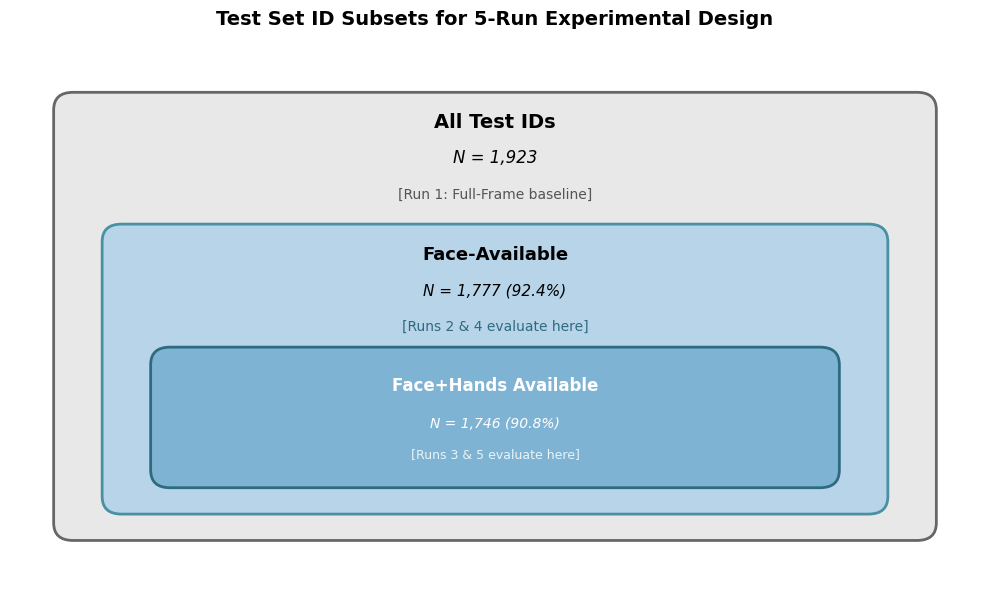

💾 Saved to /content/drive/MyDrive/TFM/outputs/figures/id_subsets_diagram.png


In [4]:
# 📊 ID Set Diagram for Thesis (Chapter 3)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis('off')

# Colors
color_all = '#E8E8E8'      # Light gray
color_face = '#B8D4E8'     # Light blue
color_fh = '#7FB3D3'       # Darker blue

# Box A: All Test IDs (outermost)
rect_all = mpatches.FancyBboxPatch(
    (0.5, 0.5), 9, 5,
    boxstyle="round,pad=0.05,rounding_size=0.2",
    facecolor=color_all, edgecolor='#666666', linewidth=2
)
ax.add_patch(rect_all)
ax.text(5, 5.1, 'All Test IDs', fontsize=14, fontweight='bold', ha='center', va='bottom')
ax.text(5, 4.7, 'N = 1,923', fontsize=12, ha='center', va='bottom', style='italic')
ax.text(5, 4.3, '[Run 1: Full-Frame baseline]', fontsize=10, ha='center', va='bottom', color='#555555')

# Box B: Face-Available (middle)
rect_face = mpatches.FancyBboxPatch(
    (1.0, 0.8), 8, 3.2,
    boxstyle="round,pad=0.05,rounding_size=0.2",
    facecolor=color_face, edgecolor='#4A90A4', linewidth=2
)
ax.add_patch(rect_face)
ax.text(5, 3.6, 'Face-Available', fontsize=13, fontweight='bold', ha='center', va='bottom')
ax.text(5, 3.2, 'N = 1,777 (92.4%)', fontsize=11, ha='center', va='bottom', style='italic')
ax.text(5, 2.8, '[Runs 2 & 4 evaluate here]', fontsize=10, ha='center', va='bottom', color='#2E6B80')

# Box C: Face+Hands Available (innermost)
rect_fh = mpatches.FancyBboxPatch(
    (1.5, 1.1), 7, 1.5,
    boxstyle="round,pad=0.05,rounding_size=0.2",
    facecolor=color_fh, edgecolor='#2E6B80', linewidth=2
)
ax.add_patch(rect_fh)
ax.text(5, 2.1, 'Face+Hands Available', fontsize=12, fontweight='bold', ha='center', va='bottom', color='white')
ax.text(5, 1.7, 'N = 1,746 (90.8%)', fontsize=10, ha='center', va='bottom', style='italic', color='white')
ax.text(5, 1.35, '[Runs 3 & 5 evaluate here]', fontsize=9, ha='center', va='bottom', color='#E8F4F8')

# Title
ax.set_title('Test Set ID Subsets for 5-Run Experimental Design', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

# Save
from pathlib import Path
OUT_ROOT = Path(os.environ.get("OUT_ROOT", "/content/drive/MyDrive/TFM/outputs"))
out_path = OUT_ROOT / "figures" / "id_subsets_diagram.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print(f"💾 Saved to {out_path}")

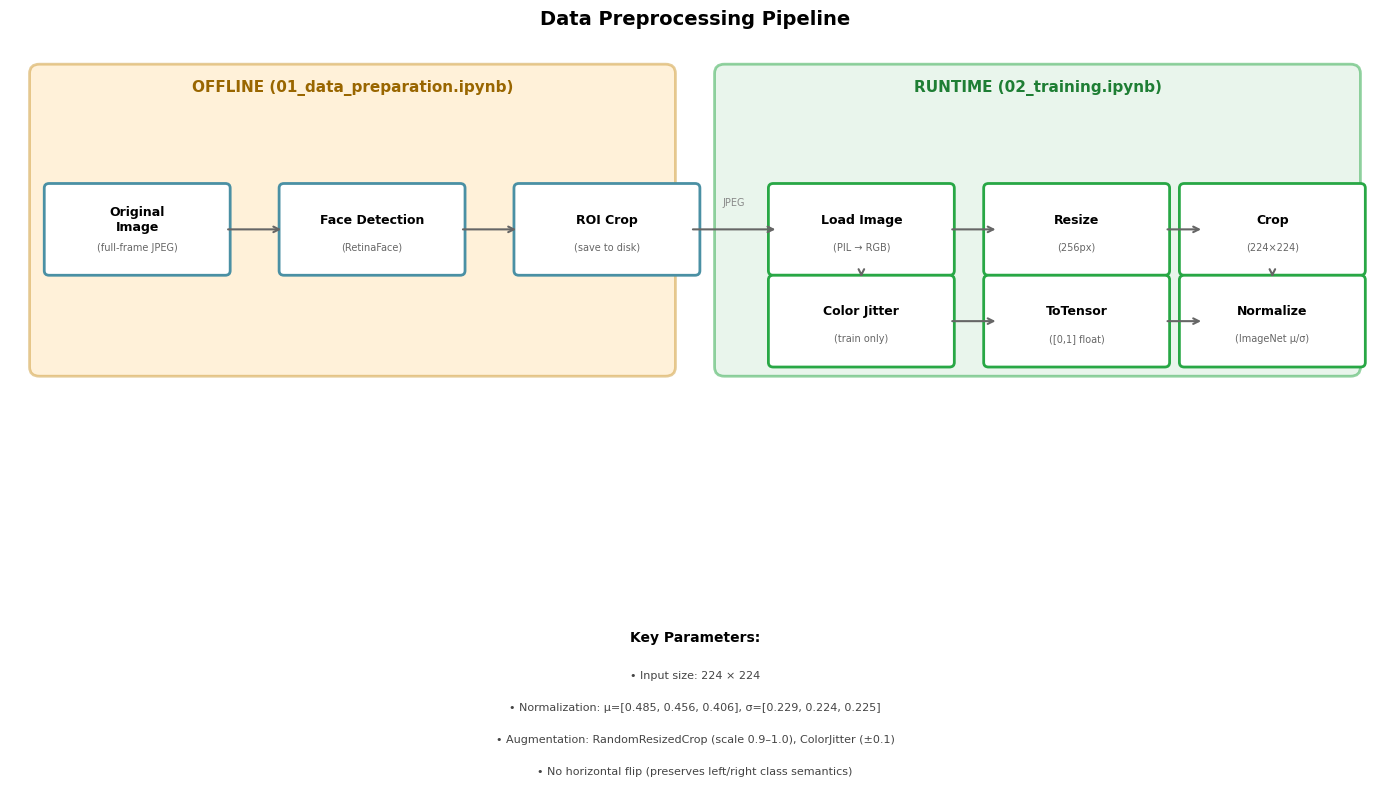

💾 Saved: /content/drive/MyDrive/TFM/outputs/figures/fig_preprocessing_pipeline.png


In [5]:
# 📊 DIAGRAM 2: Data Preprocessing Pipeline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch
from pathlib import Path
import os

fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')

# Colors
c_offline = '#FFE4B5'    # Light orange (offline)
c_runtime = '#D4EDDA'    # Light green (runtime)
c_box = '#FFFFFF'        # White boxes
c_arrow = '#666666'      # Gray arrows

# Section backgrounds
ax.add_patch(mpatches.FancyBboxPatch((0.3, 4.5), 6.4, 3.2, boxstyle="round,pad=0.1",
    facecolor=c_offline, edgecolor='#CC9933', linewidth=2, alpha=0.5))
ax.text(3.5, 7.5, 'OFFLINE (01_data_preparation.ipynb)', fontsize=11, fontweight='bold',
    ha='center', color='#996600')

ax.add_patch(mpatches.FancyBboxPatch((7.3, 4.5), 6.4, 3.2, boxstyle="round,pad=0.1",
    facecolor=c_runtime, edgecolor='#28A745', linewidth=2, alpha=0.5))
ax.text(10.5, 7.5, 'RUNTIME (02_training.ipynb)', fontsize=11, fontweight='bold',
    ha='center', color='#1E7E34')

def draw_box(x, y, text, subtext=None, width=1.8, height=0.9, color='#4A90A4'):
    box = mpatches.FancyBboxPatch((x - width/2, y - height/2), width, height,
        boxstyle="round,pad=0.05", facecolor=c_box, edgecolor=color, linewidth=2)
    ax.add_patch(box)
    ax.text(x, y + 0.1 if subtext else y, text, fontsize=9, fontweight='bold', ha='center', va='center')
    if subtext:
        ax.text(x, y - 0.2, subtext, fontsize=7, ha='center', va='center', color='#666666')

def draw_arrow(x1, y1, x2, y2, label=None):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
        arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.5))
    if label:
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2 + 0.25
        ax.text(mid_x, mid_y, label, fontsize=7, ha='center', color='#888888')

# OFFLINE STAGE
y_off = 6.0
draw_box(1.3, y_off, 'Original\nImage', '(full-frame JPEG)')
draw_arrow(2.2, y_off, 2.8, y_off)
draw_box(3.7, y_off, 'Face Detection', '(RetinaFace)')
draw_arrow(4.6, y_off, 5.2, y_off)
draw_box(6.1, y_off, 'ROI Crop', '(save to disk)')

# Arrow to runtime
draw_arrow(6.95, y_off, 7.85, y_off, 'JPEG')

# RUNTIME STAGE
y_run = 6.0
draw_box(8.7, y_run, 'Load Image', '(PIL → RGB)', color='#28A745')
draw_arrow(9.6, y_run, 10.1, y_run)
draw_box(10.9, y_run, 'Resize', '(256px)', color='#28A745')
draw_arrow(11.8, y_run, 12.2, y_run)
draw_box(12.9, y_run, 'Crop', '(224×224)', color='#28A745')

# Second row
y_run2 = 5.0
draw_box(8.7, y_run2, 'Color Jitter', '(train only)', color='#28A745')
draw_arrow(9.6, y_run2, 10.1, y_run2)
draw_box(10.9, y_run2, 'ToTensor', '([0,1] float)', color='#28A745')
draw_arrow(11.8, y_run2, 12.2, y_run2)
draw_box(12.9, y_run2, 'Normalize', '(ImageNet μ/σ)', color='#28A745')

# Connect rows
draw_arrow(12.9, y_run - 0.45, 12.9, y_run2 + 0.45)
draw_arrow(8.7, y_run - 0.45, 8.7, y_run2 + 0.45)

# Bottom: KEY INFO
ax.text(7, 1.5, 'Key Parameters:', fontsize=10, fontweight='bold', ha='center')
params = [
    'Input size: 224 × 224',
    'Normalization: μ=[0.485, 0.456, 0.406], σ=[0.229, 0.224, 0.225]',
    'Augmentation: RandomResizedCrop (scale 0.9–1.0), ColorJitter (±0.1)',
    'No horizontal flip (preserves left/right class semantics)'
]
for i, p in enumerate(params):
    ax.text(7, 1.1 - i*0.35, f'• {p}', fontsize=8, ha='center', color='#444444')

ax.set_title('Data Preprocessing Pipeline', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()

OUT_ROOT = Path(os.environ.get("OUT_ROOT", "/content/drive/MyDrive/TFM/outputs"))
out_path = OUT_ROOT / "figures" / "fig_preprocessing_pipeline.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print(f"💾 Saved: {out_path}")

/tmp/ipython-input-1261805936.py:98: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1261805936.py:103: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=200, bbox_inches='tight', facecolor='white')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


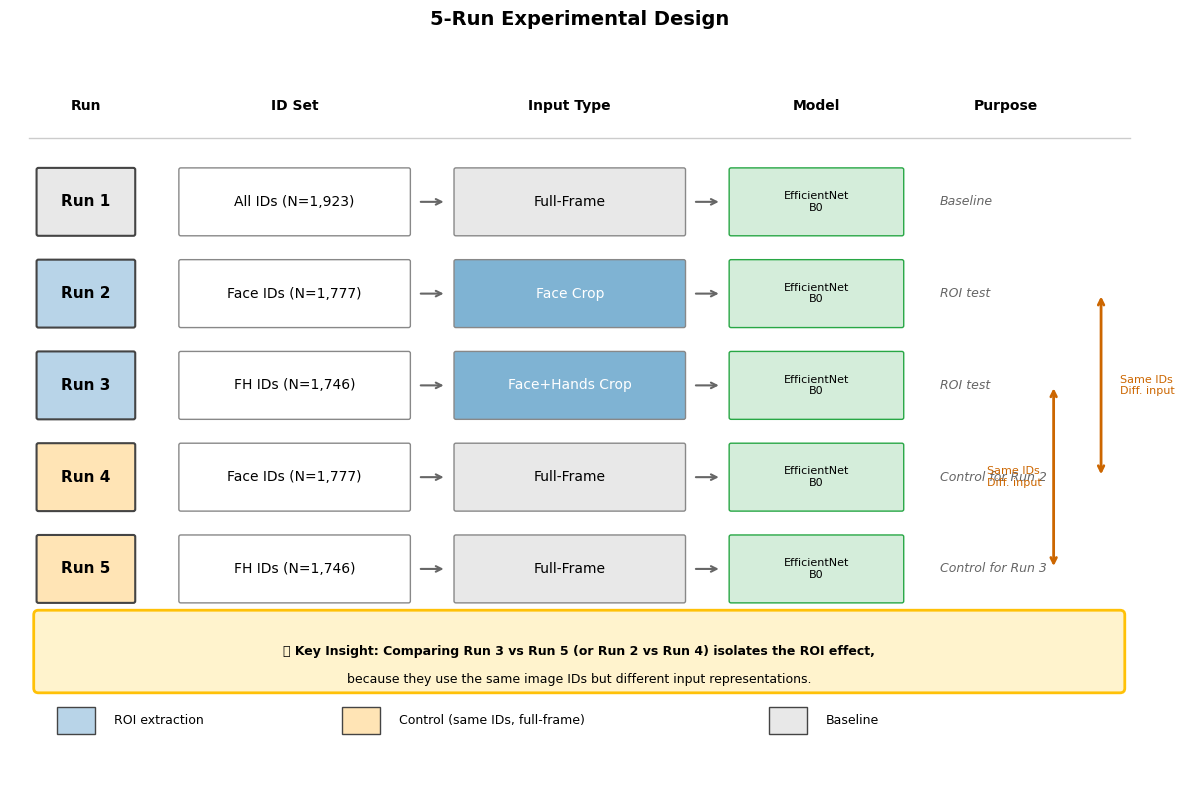

💾 Saved: /content/drive/MyDrive/TFM/outputs/figures/fig_5run_design.png


In [6]:
# 📊 DIAGRAM 3: 5-Run Experimental Design Comparison
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import os

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 8)
ax.axis('off')

# Colors
c_baseline = '#E8E8E8'     # Gray - baseline
c_roi = '#B8D4E8'          # Blue - ROI runs
c_control = '#FFE4B5'      # Orange - control runs
c_arrow = '#666666'

def draw_run_row(y, run_num, run_type, id_set, input_type, color, notes=""):
    # Run number box
    ax.add_patch(mpatches.FancyBboxPatch((0.3, y-0.35), 1.0, 0.7,
        boxstyle="round,pad=0.02", facecolor=color, edgecolor='#444444', linewidth=1.5))
    ax.text(0.8, y, f'Run {run_num}', fontsize=11, fontweight='bold', ha='center', va='center')

    # ID Set box
    ax.add_patch(mpatches.FancyBboxPatch((1.8, y-0.35), 2.4, 0.7,
        boxstyle="round,pad=0.02", facecolor='white', edgecolor='#888888', linewidth=1))
    ax.text(3.0, y, id_set, fontsize=10, ha='center', va='center')

    # Arrow
    ax.annotate('', xy=(4.6, y), xytext=(4.3, y),
        arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.5))

    # Input type box
    input_color = '#7FB3D3' if 'Crop' in input_type else '#E8E8E8'
    ax.add_patch(mpatches.FancyBboxPatch((4.7, y-0.35), 2.4, 0.7,
        boxstyle="round,pad=0.02", facecolor=input_color, edgecolor='#888888', linewidth=1))
    ax.text(5.9, y, input_type, fontsize=10, ha='center', va='center',
        color='white' if 'Crop' in input_type else 'black')

    # Arrow to model
    ax.annotate('', xy=(7.5, y), xytext=(7.2, y),
        arrowprops=dict(arrowstyle='->', color=c_arrow, lw=1.5))

    # Model box
    ax.add_patch(mpatches.FancyBboxPatch((7.6, y-0.35), 1.8, 0.7,
        boxstyle="round,pad=0.02", facecolor='#D4EDDA', edgecolor='#28A745', linewidth=1))
    ax.text(8.5, y, 'EfficientNet\nB0', fontsize=8, ha='center', va='center')

    # Notes
    if notes:
        ax.text(9.8, y, notes, fontsize=9, ha='left', va='center', color='#666666', style='italic')

# Header
ax.text(0.8, 7.3, 'Run', fontsize=10, fontweight='bold', ha='center')
ax.text(3.0, 7.3, 'ID Set', fontsize=10, fontweight='bold', ha='center')
ax.text(5.9, 7.3, 'Input Type', fontsize=10, fontweight='bold', ha='center')
ax.text(8.5, 7.3, 'Model', fontsize=10, fontweight='bold', ha='center')
ax.text(10.5, 7.3, 'Purpose', fontsize=10, fontweight='bold', ha='center')

# Separator line
ax.plot([0.2, 11.8], [7.0, 7.0], color='#CCCCCC', linewidth=1)

# Draw runs
draw_run_row(6.3, 1, 'Baseline', 'All IDs (N=1,923)', 'Full-Frame', c_baseline, 'Baseline')
draw_run_row(5.3, 2, 'ROI', 'Face IDs (N=1,777)', 'Face Crop', c_roi, 'ROI test')
draw_run_row(4.3, 3, 'ROI', 'FH IDs (N=1,746)', 'Face+Hands Crop', c_roi, 'ROI test')
draw_run_row(3.3, 4, 'Control', 'Face IDs (N=1,777)', 'Full-Frame', c_control, 'Control for Run 2')
draw_run_row(2.3, 5, 'Control', 'FH IDs (N=1,746)', 'Full-Frame', c_control, 'Control for Run 3')

# Comparison brackets
# Run 2 vs 4
ax.annotate('', xy=(11.5, 5.3), xytext=(11.5, 3.3),
    arrowprops=dict(arrowstyle='<->', color='#CC6600', lw=2))
ax.text(11.7, 4.3, 'Same IDs\nDiff. input', fontsize=8, ha='left', va='center', color='#CC6600')

# Run 3 vs 5
ax.annotate('', xy=(11.0, 4.3), xytext=(11.0, 2.3),
    arrowprops=dict(arrowstyle='<->', color='#CC6600', lw=2))
ax.text(10.3, 3.3, 'Same IDs\nDiff. input', fontsize=8, ha='left', va='center', color='#CC6600')

# Legend
ax.add_patch(mpatches.Rectangle((0.5, 0.5), 0.4, 0.3, facecolor=c_roi, edgecolor='#444'))
ax.text(1.1, 0.65, 'ROI extraction', fontsize=9, va='center')
ax.add_patch(mpatches.Rectangle((3.5, 0.5), 0.4, 0.3, facecolor=c_control, edgecolor='#444'))
ax.text(4.1, 0.65, 'Control (same IDs, full-frame)', fontsize=9, va='center')
ax.add_patch(mpatches.Rectangle((8.0, 0.5), 0.4, 0.3, facecolor=c_baseline, edgecolor='#444'))
ax.text(8.6, 0.65, 'Baseline', fontsize=9, va='center')

# Key insight box
ax.add_patch(mpatches.FancyBboxPatch((0.3, 1.0), 11.4, 0.8,
    boxstyle="round,pad=0.05", facecolor='#FFF3CD', edgecolor='#FFC107', linewidth=2))
ax.text(6, 1.4, '💡 Key Insight: Comparing Run 3 vs Run 5 (or Run 2 vs Run 4) isolates the ROI effect,',
    fontsize=9, ha='center', va='center', fontweight='bold')
ax.text(6, 1.1, 'because they use the same image IDs but different input representations.',
    fontsize=9, ha='center', va='center')

ax.set_title('5-Run Experimental Design', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()

OUT_ROOT = Path(os.environ.get("OUT_ROOT", "/content/drive/MyDrive/TFM/outputs"))
out_path = OUT_ROOT / "figures" / "fig_5run_design.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print(f"💾 Saved: {out_path}")

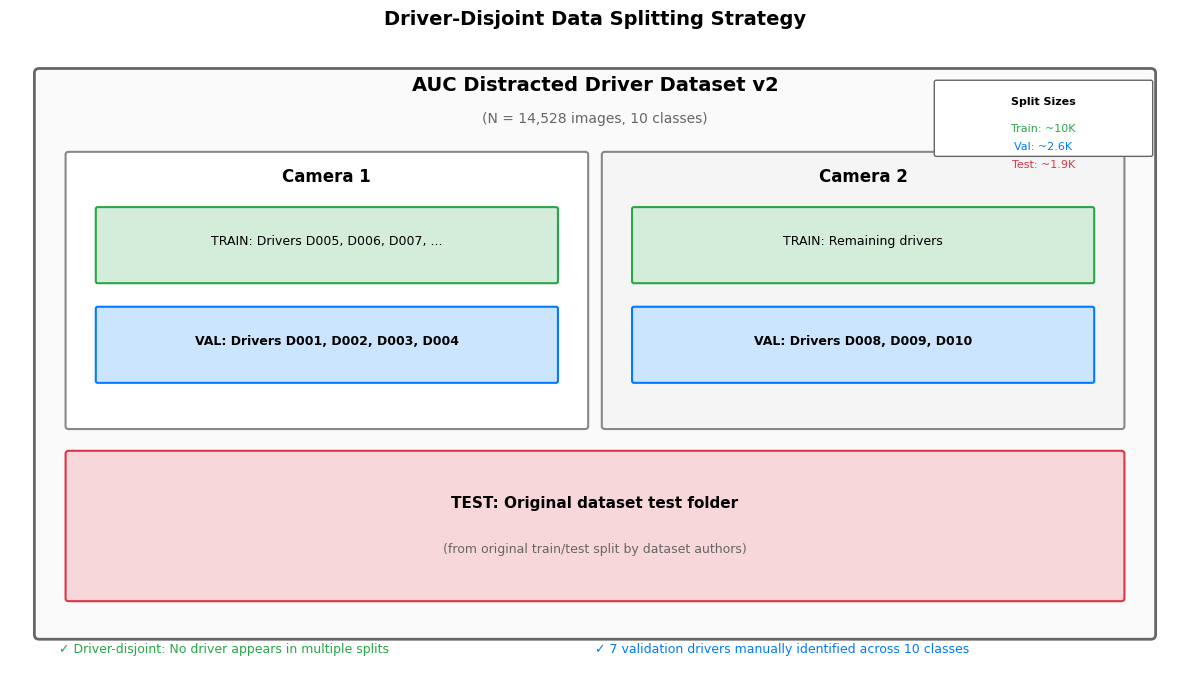

💾 Saved: /content/drive/MyDrive/TFM/outputs/figures/fig_driver_split.png


In [7]:
# 📊 DIAGRAM 4: Driver-Disjoint Data Splitting Strategy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import os

fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xlim(0, 12)
ax.set_ylim(0, 7)
ax.axis('off')

# Colors
c_train = '#D4EDDA'   # Green
c_val = '#CCE5FF'     # Blue
c_test = '#F8D7DA'    # Red/pink
c_cam1 = '#FFFFFF'
c_cam2 = '#F5F5F5'

# Main dataset box
ax.add_patch(mpatches.FancyBboxPatch((0.3, 0.5), 11.4, 6.2,
    boxstyle="round,pad=0.05", facecolor='#FAFAFA', edgecolor='#666666', linewidth=2))
ax.text(6, 6.5, 'AUC Distracted Driver Dataset v2', fontsize=14, fontweight='bold', ha='center')
ax.text(6, 6.15, '(N = 14,528 images, 10 classes)', fontsize=10, ha='center', color='#666666')

# Camera 1 section
ax.add_patch(mpatches.FancyBboxPatch((0.6, 2.8), 5.3, 3.0,
    boxstyle="round,pad=0.03", facecolor=c_cam1, edgecolor='#888888', linewidth=1.5))
ax.text(3.25, 5.5, 'Camera 1', fontsize=12, fontweight='bold', ha='center')

# Camera 2 section
ax.add_patch(mpatches.FancyBboxPatch((6.1, 2.8), 5.3, 3.0,
    boxstyle="round,pad=0.03", facecolor=c_cam2, edgecolor='#888888', linewidth=1.5))
ax.text(8.75, 5.5, 'Camera 2', fontsize=12, fontweight='bold', ha='center')

# Camera 1 drivers
ax.add_patch(mpatches.FancyBboxPatch((0.9, 4.4), 4.7, 0.8,
    boxstyle="round,pad=0.02", facecolor=c_train, edgecolor='#28A745', linewidth=1.5))
ax.text(3.25, 4.8, 'TRAIN: Drivers D005, D006, D007, ...', fontsize=9, ha='center')

ax.add_patch(mpatches.FancyBboxPatch((0.9, 3.3), 4.7, 0.8,
    boxstyle="round,pad=0.02", facecolor=c_val, edgecolor='#007BFF', linewidth=1.5))
ax.text(3.25, 3.7, 'VAL: Drivers D001, D002, D003, D004', fontsize=9, ha='center', fontweight='bold')

# Camera 2 drivers
ax.add_patch(mpatches.FancyBboxPatch((6.4, 4.4), 4.7, 0.8,
    boxstyle="round,pad=0.02", facecolor=c_train, edgecolor='#28A745', linewidth=1.5))
ax.text(8.75, 4.8, 'TRAIN: Remaining drivers', fontsize=9, ha='center')

ax.add_patch(mpatches.FancyBboxPatch((6.4, 3.3), 4.7, 0.8,
    boxstyle="round,pad=0.02", facecolor=c_val, edgecolor='#007BFF', linewidth=1.5))
ax.text(8.75, 3.7, 'VAL: Drivers D008, D009, D010', fontsize=9, ha='center', fontweight='bold')

# Test section (spans both cameras)
ax.add_patch(mpatches.FancyBboxPatch((0.6, 0.9), 10.8, 1.6,
    boxstyle="round,pad=0.03", facecolor=c_test, edgecolor='#DC3545', linewidth=1.5))
ax.text(6, 1.9, 'TEST: Original dataset test folder', fontsize=11, ha='center', fontweight='bold')
ax.text(6, 1.4, '(from original train/test split by dataset authors)', fontsize=9, ha='center', color='#666666')

# Legend and key points
ax.text(0.5, 0.3, '✓ Driver-disjoint: No driver appears in multiple splits', fontsize=9, color='#28A745')
ax.text(6, 0.3, '✓ 7 validation drivers manually identified across 10 classes', fontsize=9, color='#007BFF')

# Split counts annotation
ax.add_patch(mpatches.FancyBboxPatch((9.5, 5.8), 2.2, 0.8,
    boxstyle="round,pad=0.02", facecolor='white', edgecolor='#666666', linewidth=1))
ax.text(10.6, 6.35, 'Split Sizes', fontsize=8, fontweight='bold', ha='center')
ax.text(10.6, 6.05, 'Train: ~10K', fontsize=8, ha='center', color='#28A745')
ax.text(10.6, 5.85, 'Val: ~2.6K', fontsize=8, ha='center', color='#007BFF')
ax.text(10.6, 5.65, 'Test: ~1.9K', fontsize=8, ha='center', color='#DC3545')

ax.set_title('Driver-Disjoint Data Splitting Strategy', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()

OUT_ROOT = Path(os.environ.get("OUT_ROOT", "/content/drive/MyDrive/TFM/outputs"))
out_path = OUT_ROOT / "figures" / "fig_driver_split.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, dpi=200, bbox_inches='tight', facecolor='white')
plt.show()
print(f"💾 Saved: {out_path}")